# Siamese Network with Triplet Loss in Keras

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import random
from pca_plotter import PCAPlotter

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


## Understanding the Approach

This appraoch is taken from the popular [FaceNet](https://arxiv.org/abs/1503.03832) paper.

We have a CNN model called `EmbeddingModel`:

![CNN](assets/CNN.png)

We use three images for each training example:
1. `person1_image1.jpg` (Anchor Example, represented below in green)
2. `person1_image2.jpg` (Positive Example, in blue)
3. `person2_image1.jpg` (Negative Example, in red).

![Embeddings](assets/embeddings.png)


## Siamese Network

All the three images of an example pass through the model, and we get the three Embeddings: One for the Anchor Example, one for the Positive Example, and one for the Negative Example.

![Siamese Network](assets/siamese.png)

The three instances of the `EmbeddingModel` shown above are not different instances. It's the same, shared model instance - i.e. the parameters are shared, and are updated for all the three paths simultaneously.

# Importing the Data

In [3]:
(x_train,y_train),(x_test,y_test)= tf.keras.datasets.mnist.load_data()

In [4]:
x_train = np.reshape(x_train,(60000,784))/255.
x_test = np.reshape(x_test,(10000,784))/255.

# Plotting Examples

In [5]:
def plot_triplet(triplet):
  plt.figure(figsize=(12,6))
  for i in range(0,3):
    plt.subplot(1,3,i+1)
    plt.imshow(np.reshape(triplet[i],(28,28)),cmap='binary')
    plt.xticks([])
    plt.yticks([])
  plt.show()

<IPython.core.display.Javascript object>


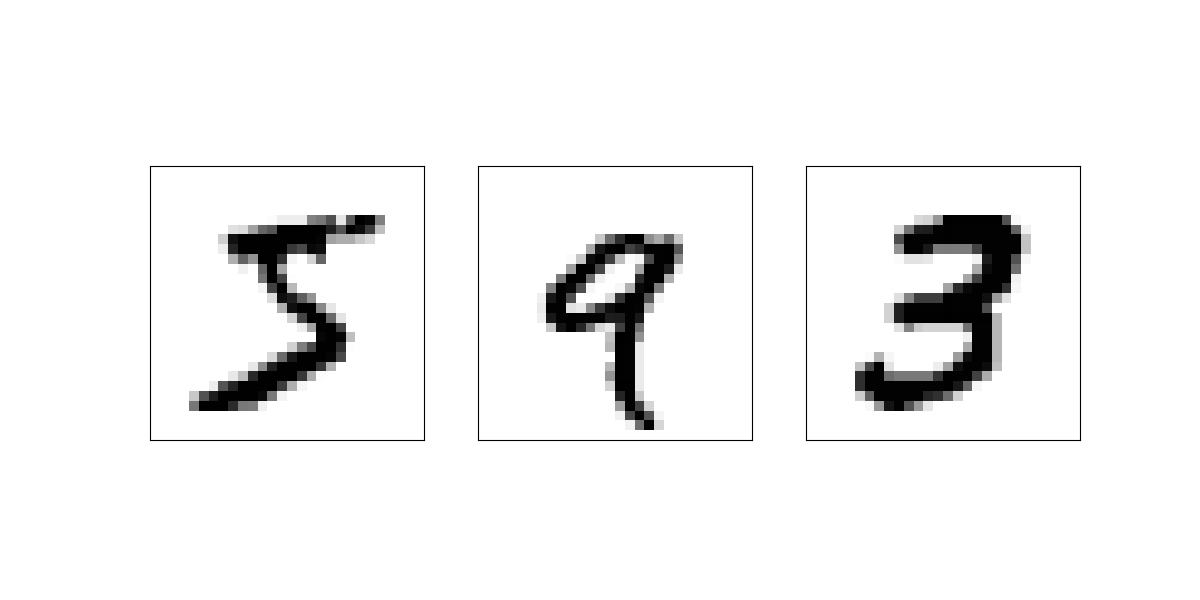

In [6]:
plot_triplet([x_train[0],x_train[4],x_train[7]])

# A Batch of Triplets

In [7]:
def create_batches(batch_size):
  anchors = np.zeros((batch_size,784))
  positive = np.zeros((batch_size,784))
  negative = np.zeros((batch_size,784))

  for i in range(0,batch_size):
    index = random.randint(0,60000-1)
    anc = x_train[index]
    y = y_train[index]
    indices_pos = np.squeeze(np.where(y_train==y))
    indices_neg = np.squeeze(np.where(y_train!=y))
    pos = x_train[indices_pos[random.randint(0,len(indices_pos)-1)]]
    neg = x_train[indices_neg[random.randint(0,len(indices_neg)-1)]]

    anchors[i] = anc
    positive[i] = pos
    negative[i] = neg
  return [anchors,positive,negative]

<IPython.core.display.Javascript object>


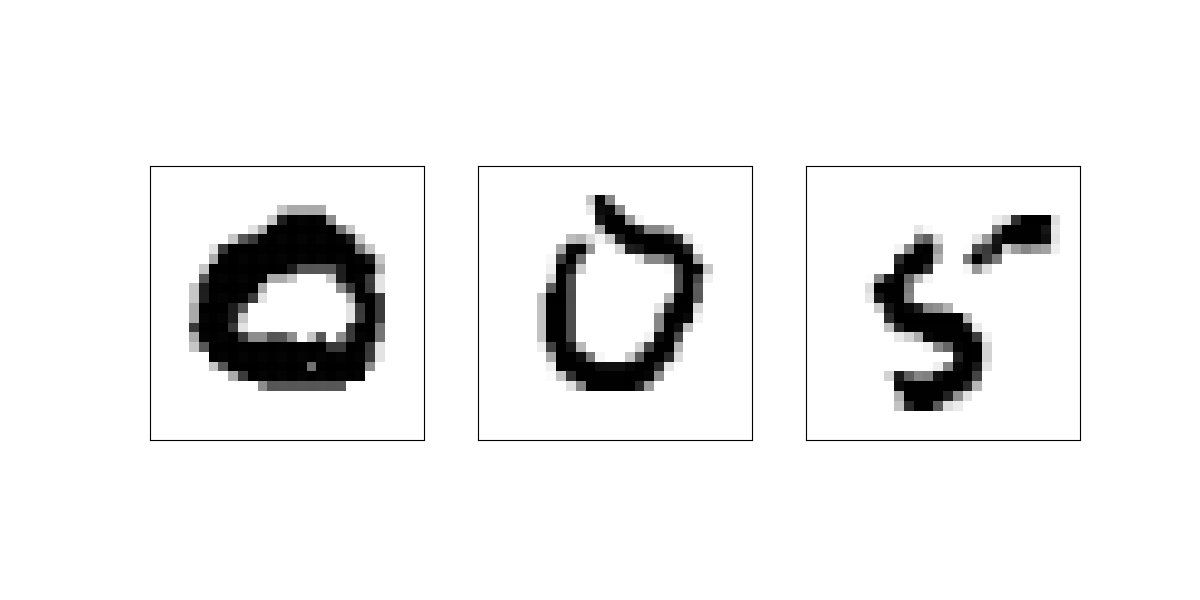

In [8]:
triplet = create_batches(1)
plot_triplet(triplet)

# Embedding Model

In [9]:
emb_dimentions = 64

embedding_model = tf.keras.models.Sequential([
tf.keras.layers.Dense(64,input_shape=(784,),activation = 'relu'),
tf.keras.layers.Dense(64,activation= 'sigmoid')])

In [10]:
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


# Siamese Network

In [11]:
in_anc = tf.keras.layers.Input(shape=(784,))
in_pos = tf.keras.layers.Input(shape=(784,))
in_neg = tf.keras.layers.Input(shape=(784,))

embedding_anc = embedding_model(in_anc)
embedding_pos = embedding_model(in_pos)
embedding_neg = embedding_model(in_neg)

output = tf.keras.layers.concatenate([embedding_anc,embedding_pos,embedding_neg],axis=1)
Siamese_network = tf.keras.models.Model(
[in_anc,in_pos,in_neg],output)

In [12]:
Siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           54400       input_1[0][0]                    
                                                                 input_2[0][0]                

#  Triplet Loss

A loss function that tries to pull the Embeddings of Anchor and Positive Examples closer, and tries to push the Embeddings of Anchor and Negative Examples away from each other.

Root mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(p_i))^2}{N}}
\end{equation}
$

Root mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(n_i))^2}{N}}
\end{equation}
$

For each example, we want:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training.

We will make it non-trivial by adding a margin (alpha):
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$

In [13]:
def triplet_loss(alpha,emb_dimentions):
  def loss(y_true,y_pred):
    anchor , positive , negative = y_pred[:,:emb_dimentions],y_pred[:,emb_dimentions:2*emb_dimentions],y_pred[:,2*emb_dimentions:]
    dp = tf.reduce_mean(tf.square(anchor-positive),axis=1)
    dn = tf.reduce_mean(tf.square(anchor-negative),axis=1)
    return tf.maximum(dp-dn+alpha,0.)
  return loss

In [14]:
Siamese_network.compile(loss = triplet_loss(alpha=0.2,emb_dimentions=emb_dimentions),optimizer='adam')

#  Data Generator

In [15]:
def generator(batch_size,emb_dimentions):
  while True:
    x = create_batches(batch_size)
    y = np.zeros((batch_size,3*emb_dimentions))
    yield x,y

In [16]:
X,Y = x_test[:1000],y_test[:1000]

# Model Training

In [17]:
batch_size = 1024
epochs = 5
steps_per_epoch = int(60000/batch_size)


<IPython.core.display.Javascript object>


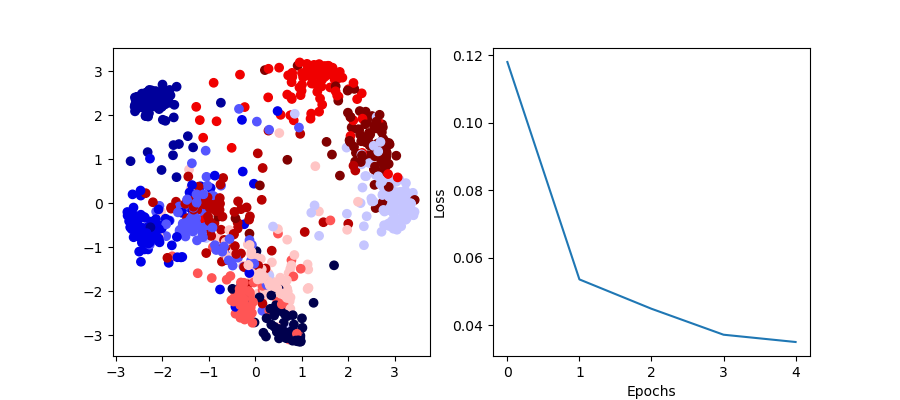

Epoch 1/5
58/58 [==============================] - 24s 410ms/step - loss: 0.1180
Epoch 2/5
58/58 [==============================] - 24s 412ms/step - loss: 0.0536
Epoch 3/5
58/58 [==============================] - 24s 415ms/step - loss: 0.0449
Epoch 4/5
58/58 [==============================] - 25s 424ms/step - loss: 0.0372
Epoch 5/5
58/58 [==============================] - 25s 430ms/step - loss: 0.0350


In [18]:
history = Siamese_network.fit(
generator(batch_size,emb_dimentions),
epochs = epochs,
steps_per_epoch = steps_per_epoch,
verbose=True,
callbacks=[
PCAPlotter(plt,embedding_model,X,Y)
])